<a href="https://colab.research.google.com/github/eklz/Project-ML-Adversarial/blob/master/Projet_Adversarial_eklz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet "apprentissage par ordinateur et exemples adversaires"
### Emile KLOTZ

Le projet porte sur un problème d'apprentissage "simple" (classification binaire), mais, à travers le prisme des exemples adversaires.

Le projet s'effectue sur les données http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html



###Définition du chemin vers les données

Le code ci dessous permet de charger les données présentes dans un répértoire Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Projet_DIR = "/content/gdrive/My Drive/TP_ARDF/"

##Prise en main et modification des données

Le code ci dessous permet de charger les données:
- Ce jeu de données permet de faire de la classification multiclasses, mais, il sera rendu binaire pour plus de simplicité: les 16 premières classes seront regroupés (limitation de vitesse et interdiction de tourner) dans la classe 1, tous les autres paneaux sont regroupés dans la classe 2.

- De plus, afin de faciliter le traitement des images, toutes les images seront ramener à des images 96x96.

- Enfin on vient transformer cet ensemble d'image en 4 matrices : - Xtrain - Xtest - Ytrain - Ytest





**Le code ci dessous mets trop longtemps à s'executer on l'execute donc en local puis on importe les matrices enregistrées**

In [0]:
import csv
import numpy as np
import PIL
import PIL.Image
import os

print("LOADING DATA")
print("rescaling all images at 96x96")
print("merging classes in 2 super classes (speed limit and turn interdiction vs all)")
Xtrain = np.zeros((4170,3,96,96),dtype=int)
Ytrain = np.zeros(4170,dtype=int)
Xtest = np.zeros((1994,3,96,96),dtype=int)
Ytest = np.zeros(1994,dtype=int)


with open(os.path.join(Projet_DIR,"TSRD-TrainAnnotation/TsignRecgTrain4170Annotation.txt")) as f:
    reader = csv.reader(f,delimiter=";")

    for i,row in enumerate(reader):
        #  Les images chargées sont redimensionnées en 96*96*3
        image3D = np.asarray(PIL.Image.open(os.path.join(Projet_DIR,"tsrd-train/"+row[0])).convert("RGB").copy().resize((96,96)),dtype=float)
        Xtrain[i] = np.transpose(image3D,(2,0,1))
        #  Les 16 premières classes seront regroupés (limitation de vitesse et interdiction de tourner) dans la classe 0, tous les autres paneaux sont regroupés dans la classe 1.
        if int(row[7])<16:
            Ytrain[i] = 0
        else:
            Ytrain[i] = 1

        
print("nb of samples with class 0/1 in train=",4170-np.sum(Ytrain),"/",np.sum(Ytrain))

# On fait la même chose avec les images de test
with open(os.path.join(Projet_DIR,"TSRD-TestAnnotation/TsignRecgTest1994Annotation.txt")) as f:
    reader = csv.reader(f,delimiter=";")
    for i,row in enumerate(reader):
      image3D = np.asarray(PIL.Image.open(os.path.join(Projet_DIR,"TSRD-Test/"+row[0])).convert("RGB").copy().resize((96,96)),dtype=float)
      Xtest[i] = np.transpose(image3D,(2,0,1))
      if int(row[7])<16:
        Ytest[i] = 0
      else:
        Ytest[i] = 1


print("nb of samples with class 0/1 in test=",1994-np.sum(Ytest),"/",np.sum(Ytest))


LOADING DATA
rescaling all images at 96x96
merging classes in 2 super classes (speed limit and turn interdiction vs all)


**On peut importer directement les matrices enregistrées en .NPY**

In [0]:
import csv
import numpy as np
import PIL
import PIL.Image
import os
Xtest=np.load((os.path.join(Projet_DIR,"Xtest.npy")))
Ytest=np.load((os.path.join(Projet_DIR,"Ytest.npy")))
Xtrain=np.load((os.path.join(Projet_DIR,"Xtrain.npy")))
Ytrain=np.load((os.path.join(Projet_DIR,"Ytrain.npy")))
print(np.shape(Xtrain))
print(np.shape(Xtest))
print("nb of samples with class 0/1 in train=",4170-np.sum(Ytrain),"/",np.sum(Ytrain))
print("nb of samples with class 0/1 in test=",1994-np.sum(Ytest),"/",np.sum(Ytest))

(4170, 3, 96, 96)
(1994, 3, 96, 96)
nb of samples with class 0/1 in train= 1520 / 2650
nb of samples with class 0/1 in test= 724 / 1270


##Référence sur les adversariaux

Indépendamment, voilà quelques liens vers des articles de référence sur les adversariaux

* Une introduction au problème des adversariaux : www.tensorflow.org/tutorials/generative/adversarial_fgsm
* L'article correspondant arxiv.org/abs/1412.6572

Du coté de la méthode de référence de "protection" contre les adversariaux
* apprendre sur des données adversaires limites leur effet arxiv.org/abs/1710.10571
* apprendre sur la pire données adversaires possibles permet d'avoir une robustesse certaines arxiv.org/abs/1711.00851

**Important** : générer des données adversaires est très simple quand on a accès au gradient vis à vis de l'image elle même (typiquement si le modèle est du deep learning). Mais c'est possible aussi en approximant le gradient d'un modèle non deep : arxiv.org/pdf/1602.02697.pdf !


##La dérivée par rapport aux données

Nous avons vu en cours que la façon même d'apprendre les poids des réseaux de neurones passe 
- par le calcul des dérivées par rapport aux valeurs des neurones
- sachant que la dérivée par rapport à un neurones se calcule via la dérivée par rapport aux neurones suivants

Cela s'applique aux valeurs des entrées !

Informatiquement, il suffit de préciser qu'on veut stocker ces dérivées pour qu'elle soit calculées en utilisant *loss.backward()*


In [0]:
import torch
import torch.nn as nn

import torch.autograd
import torch.autograd.variable

mytarget = torch.randn(1,1,4,4)
myinput = torch.autograd.Variable(torch.randn(1,3,4,4),requires_grad=True)
mymodel = nn.Conv2d(3,1,kernel_size=3, padding=1)

myloss = torch.sum((mytarget-mymodel(myinput))*(mytarget-mymodel(myinput)))

print("classical learning aims to optimize weights of mymodel to decrease loss")
print("but here, one could optimize value of myinput to increase the loss eventually producing an adversarial example")

print(myloss)
myloss.backward()

print("here is the gradient of myloss regarding myinput",myinput.grad.data)


classical learning aims to optimize weights of mymodel to decrease loss
but here, one could optimize value of myinput to increase the loss eventually producing an adversarial example
tensor(16.3831, grad_fn=<SumBackward0>)
here is the gradient of myloss regarding myinput tensor([[[[ 0.2011,  0.7462,  0.1232, -0.2176],
          [ 0.1425,  0.9595, -0.0755, -0.4835],
          [ 0.8576,  0.7974, -0.1685, -0.2317],
          [ 0.1787,  0.0275,  0.3288,  0.0316]],

         [[-0.1667,  0.4193,  0.5141, -0.2238],
          [ 0.2514,  0.8137, -0.9551, -0.3230],
          [-0.4752,  0.3194,  0.9706,  0.0412],
          [-0.0233,  0.3924,  0.1798, -0.6148]],

         [[ 1.0483,  0.6464, -0.0705, -0.8824],
          [-0.8842, -1.3365, -0.1378,  0.5013],
          [ 0.5948,  1.0562,  0.2981, -0.1826],
          [-0.5211, -0.7414, -0.3723,  0.2784]]]])


##Une baseline

Comme baseline pour commencer, il est possible (mais pas obligatoire) de considérer l'encodeur d'un VGG16 (2 convolutions - 1 pooling - 2 convolutions - 1 pooling - 3 convolutions - 1 pooling - 3 convolution - 1 pooling - 3 convolution - 1 pooling).

Appliqué à une image 3x96x96, la sortie sera une image 512x3x3 à laquel on appliquera un dernier pooling 3x3 stride 1 sans padding pour obtenir un vecteur de dimension 512, il faudra ensuite ajouter un dernier neurone pour passer de 512 à 2 valeurs (pour apprendre avec une cross entropy - 1 valeur si vous voulez apprendre en en hinge loss).

**le modèle VGG est directement téléchargeable depuis des dépôts pytorch**

In [0]:

import torchvision

monvgg16 = torchvision.models.vgg16(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
tensortest = torch.randn(1,3,96,96)
print(monvgg16.features(tensortest).shape)

torch.Size([1, 512, 3, 3])


In [0]:
monvgg16.avgpool = nn.AvgPool2d(kernel_size=(3, 3))
monvgg16.classifier = None
monvgg16.classifier = nn.Linear(512,2)
print(monvgg16(tensortest).shape)

torch.Size([1, 2])


In [0]:
monvgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Entrainement du model

In [0]:
from tqdm import tqdm # for progress bars
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

# Pytorch
import torch # deep learning framework
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn

classes = (1,2)

In [0]:
import torch
from torch.utils import data

BATCH_SIZE = 16

Xtrain=Xtrain/np.max(Xtrain)
Xtest=Xtest/np.max(Xtest)

tensor_Xtrain = torch.Tensor(Xtrain) # transform to torch tensor
tensor_Ytrain = torch.Tensor(Ytrain)

train_dataset = data.TensorDataset(tensor_Xtrain,tensor_Ytrain) # create datset
train_dataloader = data.DataLoader(train_dataset,
       batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


tensor_Xtest = torch.Tensor(Xtest)
tensor_Ytest = torch.Tensor(Ytest)
test_dataset = data.TensorDataset(tensor_Xtest,tensor_Ytest)
test_dataloader = data.DataLoader(test_dataset,
      batch_size=1, shuffle=True, num_workers=2)

In [0]:

from torch import optim
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(monvgg16.parameters(), lr = 0.005, momentum = 0.5)

In [0]:
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    i=0
    for data in loader:
        i+=1
        if i%500==0:
          print(i)
        train, y_train = data
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train.long())
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
    epoch_loss = current_loss / len(train_dataloader.dataset)
    epoch_acc = current_correct.double() / len(train_dataloader.dataset)
        
    return epoch_loss, epoch_acc

In [0]:
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        equal = (output.max(dim=1)[1] == y_valid.data)
        valid_correct += torch.sum(equal)#type(torch.FloatTensor)
    
    epoch_loss = valid_loss / len(val_dataloader.dataset)
    epoch_acc = valid_correct.double() / len(val_dataloader.dataset)
    
    return epoch_loss, epoch_acc

In [0]:
gpu=True
#freeze gradient parameters in pretrained model
for param in monvgg16.parameters():
    param.require_grad = False
#train and validate
epochs = 10  
epoch = 0
#send model to GPU
if gpu:
    monvgg16.to('cuda')
    
for e in range(epochs):
    epoch +=1
    print(epoch)
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(monvgg16,train_dataloader, criteria, gpu)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(monvgg16, val_dataloader, criteria, gpu)
print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

In [0]:
monvgg16.eval()
total = 0
correct = 0 
count = 0
#iterating for each sample in the test dataset once
for test, y_test in iter(test_dataloader):
    test, y_test = test.to('cuda'), y_test.to('cuda')
#Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = monvgg16.forward(test)
        ps = torch.exp(output)
        _, predicted = torch.max(output.data,1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item() 
        count += 1
        print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))

In [0]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_dataloader))
class_names = train_dataloader.classes
print(class_names)
rows = 4
columns = 4
fig=plt.figure()
for i in range(16):
   fig.add_subplot(rows, columns, i+1)
   plt.title(class_names[labels[i]])
   img = images[i].numpy().transpose((1, 2, 0))
   img = std * img + mean
   plt.imshow(img)
plt.show()

La fonction de loss cross_entropy donnes des resultats sur l'apprentissage qui sont bien meilleures du fait même de sa définition. De plus on ne peut pas entrainer avec la fonction de loss L2 sur des tailles de Batch supérieur à 1 ce qui entraine une durée d'entrainement bien plus élevée et un précision moindre. 


Cependant travailler avec L2 et des batchs de 1 permettra de creer des Adversarial plus efficaces l'algorithme d'apprentissage étant moins robuste et bazé sur la dérivée par rapport aux données. 

#Adversarial FSGM

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
monvgg16.cuda()
monvgg16.eval()
monvgg16.trainable=False

#Petit test pour voir si on arrive bien a faire la prediction sur une image et non tout le Dataloader
for i in range(10):
  n=randint(0,len(Xtest))
  image=torch.Tensor([Xtest[n]]).to('cuda')
  output=monvgg16(image)
  output_np = output.cpu().detach().numpy()
  print(np.argmax(output_np, axis=1).ravel(),Ytest[n])


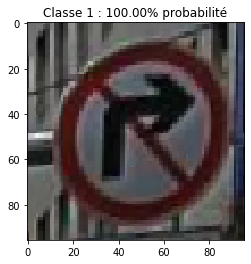

In [0]:
n=randint(0,len(Xtest))
image=torch.Tensor([Xtest[n]]).to('cuda')
label=torch.Tensor([Ytest[n]]).to('cuda')

plt.figure()
plt.imshow(np.transpose(Xtest[n],(1,2,0)))

output=monvgg16(image)
prob = F.softmax(output, 1)
prob=prob.cpu().detach().numpy()

ind=np.argmax(prob, axis=1)[0]

image_class=classes[ind]
class_confidence=prob[0][ind]

plt.title('Classe {} : {:.2f}% probabilité'.format(image_class, class_confidence*100))
plt.show()

In [0]:
epsilons = [0, .05, .1, .15, .2, .25, .3]


In [0]:
from __future__ import print_function
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [0]:
epsilons = [0, 0.01, 0.025, .05, 0.06, 0.075, .1]
pretrained_model = monvgg16
use_cuda=True

In [0]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target.long())

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []
monvgg16.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(monvgg16, 'cuda', test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 1988 / 1994 = 0.9969909729187563
Epsilon: 0.01	Test Accuracy = 1870 / 1994 = 0.9378134403209629
Epsilon: 0.025	Test Accuracy = 1638 / 1994 = 0.8214643931795386
Epsilon: 0.05	Test Accuracy = 1342 / 1994 = 0.6730190571715146
Epsilon: 0.06	Test Accuracy = 1264 / 1994 = 0.633901705115346
Epsilon: 0.075	Test Accuracy = 1236 / 1994 = 0.6198595787362087
Epsilon: 0.1	Test Accuracy = 1218 / 1994 = 0.6108324974924775


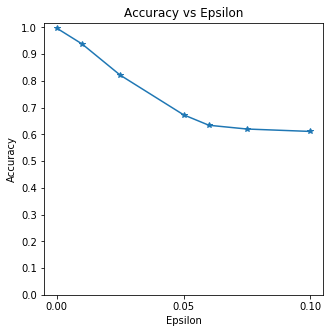

In [0]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .11, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [0]:
print(Ytrain)

NameError: ignored